## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

I will be working on understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


a. Read in the dataset and take a look at the top few rows :

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
coverted_prop =df['converted'].mean()
round(coverted_prop*100)

12

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" & landing_page !="new_page" | group == "control" & landing_page !="old_page" ').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().all().any()

False

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  


In [8]:
df2 = df.query('group == "treatment" & landing_page =="new_page" | group == "control" & landing_page =="old_page" ')

In [9]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()==True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2 = df2.loc[df2['user_id'].duplicated()==False]


D. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

E. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

F. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

G. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"')['landing_page'].count()/df2['landing_page'].count()

0.5000619442226688

E. explain  whether  there is sufficient evidence to say that the new treatment page leads to more conversions.

There is no suffiecient Evidence that the new page leads to more conversions as the probability range is too small between them 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` With  a Type I error rate of 5%, what should the  null and alternative hypotheses be?  The hypothesis in  terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<li> H0 = pold >= pnew 
<li> H1 = pold < pnew 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>


In [18]:
sample = df2.sample(df2.shape[0])

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = sample['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = sample['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page" & group == "treatment"')['landing_page'].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page" & group == "control"')['landing_page'].count()
n_old                     

145274

e. Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0, 1], n_new, p =[p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], n_old, p =[p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [25]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00010508037423939687

h. Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one  calculated in parts **a. through g.** above.  Storing all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for i in range(10000):
    bootstrap = df2.sample(df2.shape[0],replace=True)
    n_new = bootstrap.query('landing_page == "new_page" & group == "treatment"')['landing_page'].count()
    n_old = bootstrap.query('landing_page == "old_page" & group == "control"')['landing_page'].count()
    new_page_converted = np.random.choice([1, 0],n_new,p = [p_new, 1-p_new])
    old_page_converted = np.random.choice([1, 0],n_old,p = [p_old, 1-p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
   

In [27]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**. 

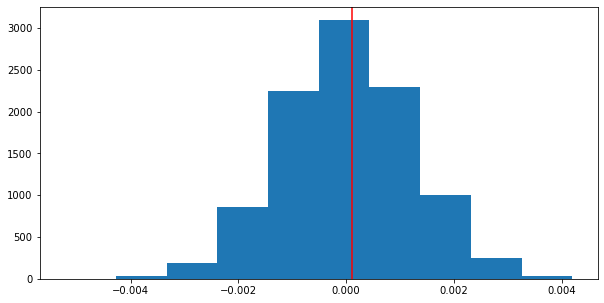

In [28]:
plt.figure(figsize=(10,5))
plt.hist(p_diffs)
plt.axvline(x= diff, color='r');
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
(p_diffs > diff).mean()

0.4607

This called p-value. and it is greater than 5% which indicate that the null hypothesis is true and the alternative is wrong in other mean rejected the alternative hypothesis

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code 

In [30]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Using `stats.proportions_ztest` to compute  test statistic and p-value

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 
print(z_score,"z_score")
print(p_value,"p_value")

1.3109241984234394 z_score
0.9050583127590245 p_value


the p_value is still higher than the 5% so the alternative hypothesis is rejected which agree with findings 

<a id='regression'></a>
### Part III - A regression approach

`1.` what type of regression should  be performing in this case?

Logistic Regression

b. create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1

In [33]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to import  regression model.  Instantiate the model, and fit the model using the two columns  created in part **b.** to predict whether or not an individual converts.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [35]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of The model below

In [36]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-23 00:48 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value  found in **Part II**?<br><br>  

the p value in regression model is 0.1899 which is diffrent than the hypothesis test and the reason in the H0 and H1 in hypothesis test and regression , in hypothesis test the H0 AND H1 ARE 
<li> H0 = p_old >= p_new 
<li> H1 = p_old < p_new 
<br>
and in the regression model the H0 AND H1 are:
<li> p_new - p_old  = 0
<li> p_new - p_old != 0

f.  why it is a good idea to consider other factors to add into  regression model.  Are there any disadvantages to adding additional terms into  regression model?

Additional factors added to the model is needed because depending on one variable to predict something is a weak model and other factors affect the prediction paramter so it is good to add more parmeter related to the prediction parameter , the disadvantage is the parameters added may influence the prediction in a bad way as it not related to the parameters so feature engineering process should be conducted to determine the best parameters to use 

g. Now along with testing if the conversion rate changes for different pages, the effect based on which country a user lives is added. 
Does it appear that country had an impact on conversion?  

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country']))

In [40]:
df_new.drop('CA',axis=1,inplace=True)

In [41]:
model = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-05-23 00:48 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

The p value of the countries shows that it doesnt affect the conversion rate as it is above 5%

h. looking at the interaction between page and country to see if there significant effects on conversion. 

In [42]:
df_new['UK_ab_page'] = df_new['UK'] *df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] *df_new['ab_page']

In [43]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [44]:
### Fit  Linear Model And Obtain the Results
model = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US','UK_ab_page','US_ab_page']])
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-05-23 00:48 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

 the interaction between the country and landing page doesnt afftect the conversion as the p values is higher than 5 % 

<a id='conclusions'></a>
## Conclusions

- Although Regresion and Hypothesis testing are diffrent methods for A/B testing but they concluded that the old page should be kept and not moving on to the new page 

